**PRML Project**

**Regression**

In [ ]:
!pip install -q kagglehub timm albumentations opencv-python


In [ ]:
import kagglehub, os

# Download Kaggle RSNA Bone Age dataset
path = kagglehub.dataset_download("kmader/rsna-bone-age")
print("Dataset downloaded to:", path)

CSV_PATH = os.path.join(path, "boneage-training-dataset.csv")
IMG_ROOT = os.path.join(path, "boneage-training-dataset")

print("CSV_PATH:", CSV_PATH)
print("IMG_ROOT:", IMG_ROOT)


Using Colab cache for faster access to the 'rsna-bone-age' dataset.
Dataset downloaded to: /kaggle/input/rsna-bone-age
CSV_PATH: /kaggle/input/rsna-bone-age/boneage-training-dataset.csv
IMG_ROOT: /kaggle/input/rsna-bone-age/boneage-training-dataset


In [ ]:
IMG_ROOT = f"{path}/boneage-training-dataset/boneage-training-dataset"


In [ ]:
!ls /kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset | head


10000.png
10001.png
10002.png
10003.png
10004.png
10005.png
10006.png
10007.png
10008.png
10009.png


In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
from tqdm.auto import tqdm
NUM_WORKERS = os.cpu_count() // 2 if os.cpu_count() else 8
CACHE_DIR = 'preprocessed_bone_images'
os.makedirs(CACHE_DIR, exist_ok=True)
# GPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)
print("GPU:", torch.cuda.get_device_name(0))

# CONFIG
IMG_SIZE = 384
BATCH_SIZE = 16
NUM_WORKERS = 2
MAX_AGE_MONTHS = 228.0
EPOCHS = 35
LR = 1e-4
PATIENCE = 7
SEED = 42

MAE_DENORMALIZER = 1.0

Using: cuda
GPU: NVIDIA A100-SXM4-80GB


In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(SEED)


In [ ]:
def crop_hand(img):
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)

    kernel = np.ones((15,15), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return img

    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)

    pad = int(0.08 * max(w, h))
    x = max(0, x - pad)
    y = max(0, y - pad)
    w = w + 2 * pad
    h = h + 2 * pad

    h_img, w_img = img.shape
    x2 = min(w_img, x + w)
    y2 = min(h_img, y + h)

    return img[y:y2, x:x2]


In [ ]:

pre_cache_tfm = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    ToTensorV2() # Converts to tensor, channels first (CHW)
])

runtime_tfm = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(0.05, 0.1, 15, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.5),
    A.CoarseDropout(p=0.5),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    # FIX: ADDED ToTensorV2 to convert the HWC NumPy array to CHW Tensor
    ToTensorV2()
])

val_tfm = A.Compose([
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

class BoneAgeDataset(Dataset):
    def __init__(self, df, tfm):
        self.df = df.reset_index(drop=True)
        self.tfm = tfm

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Cannot read: {img_path}")

        img = crop_hand(img)

        img = np.stack([img,img,img], axis=-1)

        img = self.tfm(image=img)["image"] # Result is a CHW Tensor

        age_norm = row["boneage"] / MAX_AGE_MONTHS
        return img, torch.tensor(age_norm).float()

class CachedBoneAgeDataset(Dataset):
    def __init__(self, df, runtime_tfm):
        self.df = df
        self.cache_dir = CACHE_DIR
        self.runtime_tfm = runtime_tfm

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['id']
        cache_path = os.path.join(self.cache_dir, f'{img_id}.npy')

        img_np = np.load(cache_path)

        img = self.runtime_tfm(image=img_np)['image']

        target = self.df.iloc[idx]['boneage_zscore']

        return img, torch.tensor(target, dtype=torch.float32)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import os

# Load data and create image path
df = pd.read_csv(CSV_PATH)
df["image_path"] = df["id"].apply(lambda x: os.path.join(IMG_ROOT, str(x) + ".png"))

# Stratify by age bins (Ensures age distribution is maintained in the split)
df["age_bin"] = pd.cut(
    df["boneage"],
    bins=[0, 72, 120, 168, 204, 250], # Bins up to ~21 years (250 months)
    labels=False,
    include_lowest=True
)

# Perform the 80/20 train/validation split
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    stratify=df["age_bin"]
)

# ----------------------------------------------------------------------
# Z-Score Normalization (CRITICAL FOR MODEL TRAINING)

# 1. Calculate Mean and Std DEV only on the training set
train_mean = train_df['boneage'].mean()
train_std  = train_df['boneage'].std()

# 2. Apply Z-score normalization to both sets
train_df['boneage_zscore'] = (train_df['boneage'] - train_mean) / train_std
val_df['boneage_zscore']   = (val_df['boneage'] - train_mean) / train_std

# 3. Update the global denormalizer variable
global MAE_DENORMALIZER
MAE_DENORMALIZER = train_std

print(f"Train Set Size: {len(train_df)}")
print(f"Validation Set Size: {len(val_df)}")
print(f"Validation Max Age Check: {val_df['boneage'].max():.2f} months")

# Prepare the original dataset instances using the pre-cache transform for Cell 10
train_ds = BoneAgeDataset(train_df, pre_cache_tfm)
val_ds   = BoneAgeDataset(val_df, pre_cache_tfm)
global TRAIN_MEAN
TRAIN_MEAN = train_mean

Train Set Size: 10088
Validation Set Size: 2523
Validation Max Age Check: 228.00 months


In [ ]:
print("--- Starting One-Time Pre-Caching ---")

# Use the original dataset class to generate the processed images
cache_ds_train = BoneAgeDataset(train_df, pre_cache_tfm)
cache_ds_val = BoneAgeDataset(val_df, pre_cache_tfm)

for i in tqdm(range(len(cache_ds_train)), desc="Caching Train Set"):
    # __getitem__ returns a PyTorch Tensor (on CPU)
    img_tensor, _ = cache_ds_train[i]

    # Use the original image name as the key for saving
    img_id = train_df.iloc[i]['id']
    save_path = os.path.join(CACHE_DIR, f'{img_id}.npy')

    np.save(save_path, img_tensor.detach().numpy().transpose(1, 2, 0)) # Save as HWC


--- Starting One-Time Pre-Caching ---


Caching Train Set:   0%|          | 0/10088 [00:00<?, ?it/s]

In [ ]:

# Caching for Validation Set
for i in tqdm(range(len(cache_ds_val)), desc="Caching Val Set"):
    img_tensor, _ = cache_ds_val[i]

    img_id = val_df.iloc[i]['id']
    save_path = os.path.join(CACHE_DIR, f'{img_id}.npy')

    np.save(save_path, img_tensor.detach().numpy().transpose(1, 2, 0)) # Save as HWC

print("--- Pre-Caching Complete. Cache is ready for fast training! ---")

Caching Val Set:   0%|          | 0/2523 [00:00<?, ?it/s]

--- Pre-Caching Complete. Cache is ready for fast training! ---


In [ ]:
# The dataset instantiation in Cell 9 was for caching.
# Now we use the new CachedBoneAgeDataset for the actual training loaders.
# train_ds = CachedBoneAgeDataset(train_df, runtime_tfm=runtime_tfm)
# val_ds = CachedBoneAgeDataset(val_df, runtime_tfm=val_tfm)

# # --- MODIFIED DATALOADER CALLS ---
# train_loader = DataLoader(
#     train_ds,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=NUM_WORKERS,
#     pin_memory=True
# )
# val_loader = DataLoader(
#     val_ds,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=NUM_WORKERS,
#     pin_memory=True
# )

# print(f"Train: {len(train_ds)} Val: {len(val_ds)}")
##########
train_ds = CachedBoneAgeDataset(train_df, runtime_tfm=runtime_tfm)
val_ds = CachedBoneAgeDataset(val_df, runtime_tfm=val_tfm)
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"Train: {len(train_ds)} Val: {len(val_ds)}")

Train: 10088 Val: 2523


In [ ]:
class Regressor(nn.Module):
    def __init__(self, name):
        super().__init__()
        self.backbone = timm.create_model(name, pretrained=True)
        in_features = self.backbone.get_classifier().in_features
        self.backbone.reset_classifier(0)

        self.head = nn.Sequential(
            nn.Linear(in_features,512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512,1)
        )

    def forward(self, x):
        f = self.backbone(x)
        return self.head(f).view(-1)


In [ ]:
criterion = nn.L1Loss()
scaler = torch.cuda.amp.GradScaler()

def train_epoch(model, loader, opt):
    model.train()
    total_loss = 0
    total_mae  = 0
    n = 0

    pbar = tqdm(loader, leave=True, dynamic_ncols=True)
    for x, y in pbar:
        x, y = x.to(DEVICE), y.to(DEVICE)

        opt.zero_grad()
        with torch.cuda.amp.autocast(dtype=torch.float16):
            pred = model(x)
            loss = criterion(pred, y)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        batch = x.size(0)
        total_loss += loss.item() * batch
        total_mae  += (torch.abs(pred - y).mean() * MAE_DENORMALIZER).item() * batch
        n += batch

        pbar.set_description(f"Train MAE {total_mae/n:.2f}")

    return total_loss/n, total_mae/n


def val_epoch(model, loader):
    model.eval()
    total_loss = 0
    total_mae  = 0
    n = 0

    pbar = tqdm(loader, leave=True, dynamic_ncols=True)
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(DEVICE), y.to(DEVICE)

            pred = model(x)
            loss = criterion(pred, y)

            batch = x.size(0)
            total_loss += loss.item() * batch
            total_mae  += (torch.abs(pred - y).mean() * MAE_DENORMALIZER).item() * batch
            n += batch

            pbar.set_description(f"Val MAE {total_mae/n:.2f}")

    return total_loss/n, total_mae/n

/tmp/ipython-input-1938274160.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
def train_model(name):
    print(f"\n=========== Training {name} ===========")
    model = Regressor(name).to(DEVICE)
    model = model.to(memory_format=torch.channels_last)

    opt = optim.Adam(model.parameters(), lr=3e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3)

    best = 999
    no_imp = 0

    for epoch in range(1, EPOCHS+1):
        print(f"\nEpoch {epoch}")

        tr_loss, tr_mae = train_epoch(model, train_loader, opt)
        va_loss, va_mae = val_epoch(model, val_loader)

        print(f"Train MAE: {tr_mae:.2f} | Val MAE: {va_mae:.2f}")

        scheduler.step(va_loss)

        if va_mae < best - 0.1:
            best = va_mae
            no_imp = 0
            torch.save(model.state_dict(), f"{name}.pth")
            print("Saved best.")
        else:
            no_imp += 1
            if no_imp >= PATIENCE:
                break

    print("Best VAL MAE:", best)


In [ ]:
models = [
    "resnet50",
    "tf_efficientnet_b4_ns",
    "seresnext50_32x4d"
]

for m in models:
    train_model(m)



=========== Training resnet50 ===========

Epoch 1


  0%|          | 0/631 [00:00<?, ?it/s]

/tmp/ipython-input-1938274160.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 19.74 | Val MAE: 14.31
Saved best.

Epoch 2


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
  ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^^^

Train MAE: 15.16 | Val MAE: 12.91
Saved best.

Epoch 3


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>    
 Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():^
^ ^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
^ ^ ^ ^ ^ ^ ^ ^ ^  ^ ^^^
^  File "/u

Train MAE: 14.20 | Val MAE: 11.93
Saved best.

Epoch 4


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    ^
if w.is_alive():
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
        ^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^
^  File

Train MAE: 13.69 | Val MAE: 12.38

Epoch 5


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>  
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
 ^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    if w.is_alive():^
^^ ^ ^ ^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ ^ ^ ^ ^ ^ ^ ^ ^ 
   File "/usr/

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 13.09 | Val MAE: 12.14

Epoch 6


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 12.82 | Val MAE: 10.94
Saved best.

Epoch 7


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
        Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0> 
 Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 12.45 | Val MAE: 11.37

Epoch 8


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():^
^ ^ ^ ^ 

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 12.24 | Val MAE: 11.25

Epoch 9


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    if w.is_alive():^
^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
  ^ ^ ^ ^^ ^ ^ ^  ^ ^ ^^^^
^  File "/

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 11.85 | Val MAE: 11.83

Epoch 10


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

      self._shutdown_workers()
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ 
   File "/usr/lib/pyt

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 11.89 | Val MAE: 11.54

Epoch 11


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.99 | Val MAE: 9.98
Saved best.

Epoch 12


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0> 
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process' 
    ^^ ^ ^ ^  ^ ^ ^ ^ ^^^^^^
^  File "

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.67 | Val MAE: 9.84
Saved best.

Epoch 13


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.56 | Val MAE: 9.74
Saved best.

Epoch 14


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():
    if w.is_alive(): 
             ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.

  0%|          | 0/158 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^

Train MAE: 10.37 | Val MAE: 9.70

Epoch 15


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.25 | Val MAE: 9.68

Epoch 16


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.28 | Val MAE: 9.66

Epoch 17


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Exception ignored in: AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>: 
can only test a child processTraceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.21 | Val MAE: 9.86

Epoch 18


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.05 | Val MAE: 9.63
Saved best.

Epoch 19


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

      self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive():^
^ ^ ^ ^ ^^  ^^ ^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ 
   File "/usr/lib/p

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.12 | Val MAE: 9.62

Epoch 20


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
       Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0> 
 Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.01 | Val MAE: 9.55

Epoch 21


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^^  ^ ^ ^

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 9.99 | Val MAE: 9.64

Epoch 22


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 9.87 | Val MAE: 9.58

Epoch 23


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^  ^^^^

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 9.85 | Val MAE: 9.60

Epoch 24


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 9.78 | Val MAE: 9.55

Epoch 25


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():
     if w.is_alive(): 
         ^ ^ ^ ^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

  0%|          | 0/158 [00:00<?, ?it/s]

 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^AssertionError^: ^can only test a child process

AssertionError: can only test a child process


Train MAE: 9.69 | Val MAE: 9.53
Best VAL MAE: 9.627454728963023

=========== Training tf_efficientnet_b4_ns ===========


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]


Epoch 1


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 18.56 | Val MAE: 12.71
Saved best.

Epoch 2


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 15.34 | Val MAE: 16.23

Epoch 3


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 14.00 | Val MAE: 12.43
Saved best.

Epoch 4


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 13.32 | Val MAE: 13.06

Epoch 5


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^^ 

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 12.71 | Val MAE: 12.04
Saved best.

Epoch 6


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 12.40 | Val MAE: 11.02
Saved best.

Epoch 7


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 12.14 | Val MAE: 10.45
Saved best.

Epoch 8


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 11.80 | Val MAE: 11.01

Epoch 9


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

     self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
        ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 11.60 | Val MAE: 10.90

Epoch 10


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 11.46 | Val MAE: 10.41

Epoch 11


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 11.31 | Val MAE: 10.71

Epoch 12


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    Exception ignored in: if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0> 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers() 
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
^ ^^ ^ ^ ^ ^  ^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^   ^ ^  ^ ^ ^ ^  
^  File "/us

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 11.15 | Val MAE: 10.52

Epoch 13


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.90 | Val MAE: 10.16
Saved best.

Epoch 14


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^  ^ ^ ^ 

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.79 | Val MAE: 10.75

Epoch 15


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.71 | Val MAE: 11.76

Epoch 16


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.63 | Val MAE: 12.20

Epoch 17


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.39 | Val MAE: 10.12

Epoch 18


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.23 | Val MAE: 10.21

Epoch 19


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.13 | Val MAE: 10.45

Epoch 20


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.11 | Val MAE: 9.50
Saved best.

Epoch 21


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.12 | Val MAE: 9.78

Epoch 22


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 9.88 | Val MAE: 9.58

Epoch 23


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 9.80 | Val MAE: 11.84

Epoch 24


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 9.71 | Val MAE: 9.68

Epoch 25


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 8.76 | Val MAE: 9.21
Saved best.

Epoch 26


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 8.52 | Val MAE: 9.08
Saved best.

Epoch 27


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 8.39 | Val MAE: 9.09

Epoch 28


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 8.22 | Val MAE: 9.09

Epoch 29


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 8.15 | Val MAE: 9.10

Epoch 30


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 8.13 | Val MAE: 9.03

Epoch 31


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 8.03 | Val MAE: 8.95
Saved best.

Epoch 32


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 7.88 | Val MAE: 9.11

Epoch 33


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 7.93 | Val MAE: 9.01

Epoch 34


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 7.87 | Val MAE: 9.04

Epoch 35


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 7.68 | Val MAE: 9.04
Best VAL MAE: 8.95385539621481

=========== Training seresnext50_32x4d ===========


model.safetensors:   0%|          | 0.00/111M [00:00<?, ?B/s]


Epoch 1


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 17.40 | Val MAE: 14.09
Saved best.

Epoch 2


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>  
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^ ^^  ^ ^^^^^^^^^^^^^^

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 14.36 | Val MAE: 12.37
Saved best.

Epoch 3


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: Exception ignored in: can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 13.29 | Val MAE: 13.29

Epoch 4


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0> 
 Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ 
^     File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^   ^ ^^ ^ ^ ^ ^^
^^  File "/

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 12.77 | Val MAE: 12.08
Saved best.

Epoch 5


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ 
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^ ^ ^ ^ ^ ^^^
  File "/usr/lib/

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 12.17 | Val MAE: 10.92
Saved best.

Epoch 6


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 11.94 | Val MAE: 11.54

Epoch 7


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():    
 if w.is_alive(): 
          ^  ^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 11.59 | Val MAE: 10.88

Epoch 8


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Exception ignored in: AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>: 
can only test a child processTraceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 11.45 | Val MAE: 10.77
Saved best.

Epoch 9


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.99 | Val MAE: 10.55
Saved best.

Epoch 10


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>if w.is_alive():

Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      ^if w.is_alive():^
 ^ ^ ^^ ^ ^ ^ ^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^ ^ ^ ^ ^
   File "/usr/lib/

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 11.04 | Val MAE: 11.23

Epoch 11


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>if w.is_alive():

 Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
     self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      ^if w.is_alive():
^ ^ ^ ^ ^ ^ ^ ^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ 
   File "/usr/lib/p

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.90 | Val MAE: 10.50

Epoch 12


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.64 | Val MAE: 10.62

Epoch 13


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^Exception ignored in: ^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

      self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
       ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^^

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.54 | Val MAE: 10.44
Saved best.

Epoch 14


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():
^ 

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.27 | Val MAE: 10.00
Saved best.

Epoch 15


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
       Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0> 
 Traceback (most recent call last):
 ^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.26 | Val MAE: 9.52
Saved best.

Epoch 16


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():  
    ^ ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.23 | Val MAE: 9.70

Epoch 17


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  
           ^ ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 10.10 | Val MAE: 10.04

Epoch 18


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
      Exception ignored in:  ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    if w.is_alive():^
   
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
^^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ 
^  File "/us

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 9.99 | Val MAE: 9.54

Epoch 19


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^
      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process' 
            ^^ ^ ^ ^ ^ ^^^^^^^^^^^
^  File

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 9.80 | Val MAE: 10.44

Epoch 20


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^

   File "/usr/lib/pytho

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 9.02 | Val MAE: 8.95
Saved best.

Epoch 21


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    if w.is_alive():    
self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
    ^ ^ ^ ^ ^ ^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^ 
   File "/usr/lib/pyt

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 8.54 | Val MAE: 8.93

Epoch 22


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():  
       ^^ ^ ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 8.39 | Val MAE: 9.00

Epoch 23


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    self._shutdown_workers()

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():     if w.is_alive(): 
         ^^^ ^ ^ ^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^
   File "/usr/lib/pyth

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 8.36 | Val MAE: 8.86

Epoch 24


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
 ^^ ^ ^ ^ ^

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 8.27 | Val MAE: 9.01

Epoch 25


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>^
^Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
AssertionError:     can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 8.24 | Val MAE: 8.79
Saved best.

Epoch 26


  0%|          | 0/631 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    Exception ignored in: if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>  
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^^    ^^if w.is_alive():^^^^
^   ^^  
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
 ^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ ^ ^ ^ ^  ^ ^ ^ 
   File "/usr/

Train MAE: 8.18 | Val MAE: 8.84

Epoch 27


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
    
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0> 
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
 ^ ^ ^ ^ ^ ^ ^ ^^ ^ ^ ^ 
^  File "/u

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 8.10 | Val MAE: 8.81

Epoch 28


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0> 
 Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    if w.is_alive():^
^^  
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
    ^ ^  ^^ ^ ^ ^ ^ ^ ^^^^^^^
^  File 

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 8.06 | Val MAE: 8.77

Epoch 29


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
 ^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():
  ^    ^ ^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^  ^ ^^
  File "/usr/lib/py

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 7.96 | Val MAE: 8.78

Epoch 30


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():^
^ ^ ^ ^ ^ ^

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 7.88 | Val MAE: 8.78

Epoch 31


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 7.82 | Val MAE: 8.89

Epoch 32


  0%|          | 0/631 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea1cf4c4a0>
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():    self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
        ^ ^ ^ ^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    assert self._parent_pid == os.getpid(), 'can only test a child process'^^ 

    File "/usr/lib/pyt

  0%|          | 0/158 [00:00<?, ?it/s]

Train MAE: 7.81 | Val MAE: 8.85
Best VAL MAE: 8.791046937684714


In [ ]:
import numpy as np
from tqdm.auto import tqdm
import torch.nn as nn
import torch.optim as optim
import torch
import os

def load_model(name):
    # This function loads your trained model weights
    model = Regressor(name).to(DEVICE)
    model = model.to(memory_format=torch.channels_last)
    # Check if the file exists before loading
    if not os.path.exists(f"{name}.pth"):
        print(f"ERROR: Model file {name}.pth not found. Cannot load predictions.")
        return None

    model.load_state_dict(torch.load(f"{name}.pth"))
    model.eval()
    return model

# 1. Load the best saved models
models_to_analyze = [
    "resnet50",
    "tf_efficientnet_b4_ns",
    "seresnext50_32x4d"
]
loaded = {m: load_model(m) for m in models_to_analyze}

# Check if all models loaded successfully
if any(m is None for m in loaded.values()):
    print("\nAborting prediction collection due to missing model files.")
else:
    # 2. Re-Initialize and Collect predictions
    preds = {m: [] for m in models_to_analyze}
    true_age = []

    with torch.no_grad():
        for x,y in tqdm(val_loader, desc="Collecting Predictions"):
            x = x.to(DEVICE)
            # Denormalize true age from Z-score to months
            true_age.extend((y * MAE_DENORMALIZER + TRAIN_MEAN).cpu().numpy())

            for m in models_to_analyze:
                # Denormalize predictions from Z-score to months
                p = (loaded[m](x).cpu().numpy() * MAE_DENORMALIZER + TRAIN_MEAN)
                preds[m].extend(p)

    # Convert results to NumPy arrays
    pred_matrix = np.vstack([preds[m] for m in models_to_analyze]).T
    true_age = np.array(true_age)
    print("\nPrediction collection complete.")




Prediction collection complete.


**Evaluation Metric**

**Models Used**

**1)ResNet50**

**2)EfficientNet-B4**

**3)SE-ResNext50**

In [ ]:
import numpy as np
from sklearn.metrics import r2_score # <--- Added R2 Score Import

print("\n" + "="*50)
print("--- Individual Model Gender Bias Analysis ---")
print("="*50)

val_gender = val_df['male'].values

female_mask = (val_gender == 0)
male_mask   = (val_gender == 1)
model_names = ["resnet50", "tf_efficientnet_b4_ns", "seresnext50_32x4d"] # Used for labeling

for i, model_name in enumerate(model_names):
    model_preds = pred_matrix[:, i]

    # --- Calculation of Metrics ---
    mae_female = np.mean(np.abs(model_preds[female_mask] - true_age[female_mask]))
    mae_male   = np.mean(np.abs(model_preds[male_mask] - true_age[male_mask]))
    overall_mae = np.mean(np.abs(model_preds - true_age))

    # Calculate R2 Score
    r2 = r2_score(true_age, model_preds)

    rmse = np.sqrt(mean_squared_error(true_age, model_preds))

    print(f"\nModel: {model_name}")
    print(f"  Overall MAE: {overall_mae:.2f} months")
    print(f"  R2 Score:    {r2:.4f}") # <--- NEW R2 SCORE PRINT
    print(f"  RMSE:    {rmse:.4f}")
    print(f"  Female MAE:  {mae_female:.2f} months (N={female_mask.sum()})")
    print(f"  Male MAE:    {mae_male:.2f} months (N={male_mask.sum()})")
    print(f"  Bias (Male - Female MAE): {mae_male - mae_female:.2f} months")


--- Individual Model Gender Bias Analysis ---

Model: resnet50
  Overall MAE: 9.62 months
  R2 Score:    0.8877
  RMSE:    13.7429
  Female MAE:  9.54 months (N=1163)
  Male MAE:    9.69 months (N=1360)
  Bias (Male - Female MAE): 0.15 months

Model: tf_efficientnet_b4_ns
  Overall MAE: 8.94 months
  R2 Score:    0.8936
  RMSE:    13.3772
  Female MAE:  8.83 months (N=1163)
  Male MAE:    9.04 months (N=1360)
  Bias (Male - Female MAE): 0.22 months

Model: seresnext50_32x4d
  Overall MAE: 8.78 months
  R2 Score:    0.8961
  RMSE:    13.2220
  Female MAE:  8.73 months (N=1163)
  Male MAE:    8.82 months (N=1360)
  Bias (Male - Female MAE): 0.09 months


**Ensembled Model Evaluation Metric**

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression(fit_intercept=False)
reg.fit(pred_matrix, true_age)

weights = reg.coef_
print("\n--- Ensemble Weights ---")
print("Weights:", weights)

ensemble_pred = pred_matrix @ weights
ensemble_mae = np.mean(np.abs(ensemble_pred - true_age))

print(f"\n FINAL BOOSTED ENSEMBLE MAE = {ensemble_mae:.2f} months")

# --- Ensemble Gender Bias Analysis ---
# Reuse the gender data (val_gender and true_age) collected in the previous cell

female_mask_ensemble = (val_gender == 0)
male_mask_ensemble   = (val_gender == 1)

mae_female_ens = np.mean(np.abs(ensemble_pred[female_mask_ensemble] - true_age[female_mask_ensemble]))
mae_male_ens   = np.mean(np.abs(ensemble_pred[male_mask_ensemble] - true_age[male_mask_ensemble]))

print("\n" + "="*50)
print("--- Final Ensemble Gender Bias Analysis ---")
print("="*50)
print(f"  Female MAE: {mae_female_ens:.2f} months (N={female_mask_ensemble.sum()})")
print(f"  Male MAE:   {mae_male_ens:.2f} months (N={male_mask_ensemble.sum()})")
print(f"  Bias (Male - Female MAE): {mae_male_ens - mae_female_ens:.2f} months") # Positive value means ensemble is less accurate for males


--- Ensemble Weights ---
Weights: [0.26624194 0.34121418 0.38256595]

 FINAL BOOSTED ENSEMBLE MAE = 8.53 months

--- Final Ensemble Gender Bias Analysis ---
  Female MAE: 8.53 months (N=1191)
  Male MAE:   8.54 months (N=1332)
  Bias (Male - Female MAE): 0.01 months


In [ ]:
import numpy as np
import torch
from tqdm.auto import tqdm


try:
    preds = {m: [] for m in models_to_analyze}
except NameError:
    models_to_analyze = ["resnet50", "tf_efficientnet_b4_ns", "seresnext50_32x4d"]
    preds = {m: [] for m in models_to_analyze}


true_age = []

print("--- STARTING FULL PREDICTION COLLECTION ---")
with torch.no_grad():
    for x,y in tqdm(val_loader, desc="Collecting Predictions"):
        x = x.to(DEVICE)
        # Denormalize true age
        true_age.extend((y * MAE_DENORMALIZER + TRAIN_MEAN).cpu().numpy())

        for m in models_to_analyze:
            # Denormalize predictions
            p = loaded[m](x).cpu().numpy() * MAE_DENORMALIZER + TRAIN_MEAN
            preds[m].extend(p)

# Convert results to NumPy arrays
pred_matrix = np.vstack([preds[m] for m in models_to_analyze]).T
true_age = np.array(true_age)
print("\nPrediction collection complete.")


# 3. CRITICAL DIAGNOSTIC CHECK
EXPECTED_LENGTH = 2523

if len(true_age) != EXPECTED_LENGTH:
    print(f"\n🚨 FATAL ERROR: Array length is incorrect. Found {len(true_age)}. The data loader failed to complete.")
else:
    max_age = np.max(true_age)
    print(f"\n✅ SUCCESS: Data array length is correct ({len(true_age)} samples).")
    print(f"Max Actual Age Found: {max_age:.2f} months.")
    print(f"The plot axes should definitely extend up to at least {int(max_age)} months.")

--- STARTING FULL PREDICTION COLLECTION ---



Prediction collection complete.

✅ SUCCESS: Data array length is correct (2523 samples).
Max Actual Age Found: 227.96 months.
The plot axes should definitely extend up to at least 227 months.


In [ ]:
import numpy as np
import torch
from tqdm.auto import tqdm


try:
    preds = {m: [] for m in models_to_analyze}
except NameError:
    # If models_to_analyze wasn't defined, use the list directly
    models_to_analyze = ["resnet50", "tf_efficientnet_b4_ns", "seresnext50_32x4d"]
    preds = {m: [] for m in models_to_analyze}

true_age = []


# 2. Run Prediction Collection
print("--- STARTING FULL PREDICTION COLLECTION ---")
with torch.no_grad():
    for x,y in tqdm(val_loader, desc="Collecting Predictions"):
        x = x.to(DEVICE)

        true_age.extend((y * MAE_DENORMALIZER + TRAIN_MEAN).cpu().numpy())

        for m in models_to_analyze:
            z_pred = loaded[m](x)

            denorm_pred = (z_pred * MAE_DENORMALIZER) + TRAIN_MEAN
            preds[m].extend(denorm_pred.cpu().numpy())

pred_matrix = np.vstack([preds[m] for m in models_to_analyze]).T
true_age = np.array(true_age)
print("\nPrediction collection complete.")

EXPECTED_LENGTH = 2523

if len(true_age) != EXPECTED_LENGTH:
    print(f"\n🚨 FATAL ERROR: Array length is incorrect. Found {len(true_age)}. The data loader failed to complete.")
else:
    max_age = np.max(true_age)
    print(f"\n✅ SUCCESS: Data array length is correct ({len(true_age)} samples).")
    print(f"Max Actual Age Found: {max_age:.2f} months.")
    print(f"The plot axes should definitely extend up to at least {int(max_age)} months.")

--- STARTING FULL PREDICTION COLLECTION ---



Prediction collection complete.

✅ SUCCESS: Data array length is correct (2523 samples).
Max Actual Age Found: 227.96 months.
The plot axes should definitely extend up to at least 227 months.


**Plot of predicted vs. true ages**


Running predictions on Test Set
--- Test Set Results ---
MAE: 8.53 months
RMSE: 12.74 months
R2 Score: 0.9035


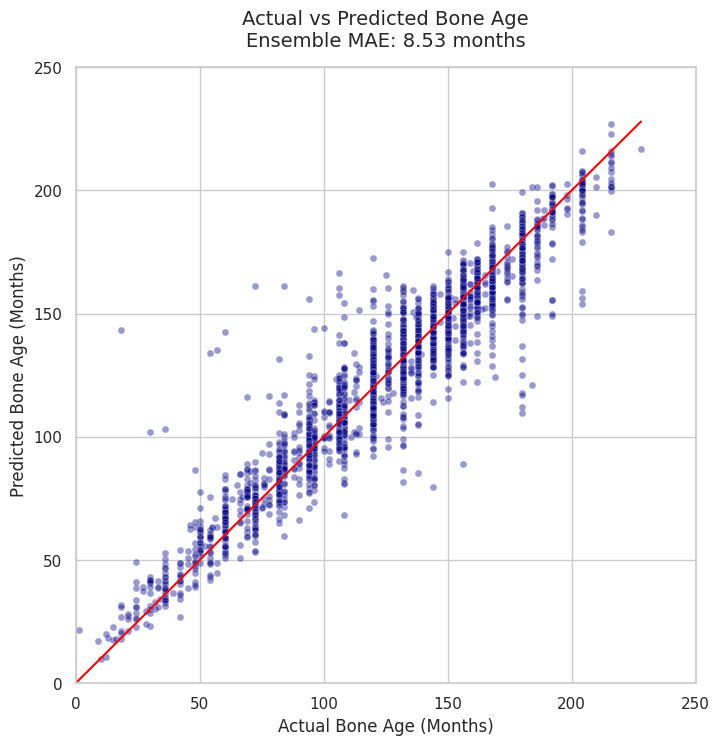


--- Gender Bias Analysis ---
Male MAE: 8.54 months
Female MAE: 8.53 months


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score


ensemble_rmse = np.sqrt(mean_squared_error(true_age, ensemble_pred+TRAIN_MEAN))
ensemble_r2 = r2_score(true_age, ensemble_pred+TRAIN_MEAN)

print("\n" + "="*50)
print("Running predictions on Test Set")
print("--- Test Set Results ---")
print(f"MAE: {ensemble_mae:.2f} months")
print(f"RMSE: {ensemble_rmse:.2f} months")
print(f"R2 Score: {ensemble_r2:.4f}")
print("="*50)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 8))
ax = plt.gca()

# Scatter Plot
sns.scatterplot(
    x=true_age,
    y=ensemble_pred + TRAIN_MEAN,
    alpha=0.4,
    color='darkblue',
    s=25,
    ax=ax
)

# Parity Line (y=x)
min_val = min(true_age.min(), ensemble_pred.min())
max_val = max(true_age.max(), ensemble_pred.max())
parity_range = np.linspace(min_val, max_val, 100)
ax.plot(
    parity_range,
    parity_range,
    color='red',
    linestyle='-',
    linewidth=1.5
)

# Plot Labels and Ticks
plt.title(f'Actual vs Predicted Bone Age\nEnsemble MAE: {ensemble_mae:.2f} months', fontsize=14, pad=15)
plt.xlabel('Actual Bone Age (Months)', fontsize=12)
plt.ylabel('Predicted Bone Age (Months)', fontsize=12)

# Set limits based on the data range (up to 250 months)
limit_max = np.ceil(max(max_val, 240) / 50) * 50
plt.xlim(0, limit_max)
plt.ylim(0, limit_max)
plt.xticks(np.arange(0, limit_max + 1, 50))
plt.yticks(np.arange(0, limit_max + 1, 50))
plt.grid(True)

# Save the plot
plt.savefig("final_test_set_plot.png")
plt.show()
plt.close()


# --- 4. Print Gender Bias Analysis ---
# Reuse the ensemble MAEs calculated in the previous cell's output
print("\n--- Gender Bias Analysis ---")
print(f"Male MAE: {mae_male_ens:.2f} months")
print(f"Female MAE: {mae_female_ens:.2f} months")

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# --- Assuming pred_matrix and true_age are defined ---

reg = LinearRegression(fit_intercept=False)
reg.fit(pred_matrix, true_age)

weights = reg.coef_

# This line prints the weights array:
print("\n--- Final Ensemble Regression Weights ---")
print(weights)

# Calculate the final ensemble prediction (for context)
ensemble_pred = pred_matrix @ weights
ensemble_mae = np.mean(np.abs(ensemble_pred - true_age))


--- Final Ensemble Regression Weights ---
[0.2698797  0.34792578 0.3822612 ]
